# Анализ групп и AB тест для приложения доставки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ab_orders = pd.read_csv('~/ab_orders.csv')
ab_products = pd.read_csv('~/ab_products.csv')
ab_users_data = pd.read_csv('ab_users_data.csv')

### Посмотрим на данные в датафрейме:

#### Датафрейм 1. Подробная информация о составе заказа

In [3]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [4]:
ab_orders.query('order_id == "1258"')
#тут отмены не учитываются - только покупка, отметим это (исходя из данных ниже)

,order_id,creation_time,product_ids
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"


In [5]:
ab_orders.shape

(4123, 3)

In [6]:
ab_orders.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

##### Посмотрим сколько уникальных заказов. Столько, сколько и строк, всё нормально

In [7]:
ab_orders.order_id.nunique()

4123

#### Датафрейм 2. История заказов пользователей

In [8]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


##### Строк больше, чем в датафрейме с составом заказов

In [9]:
ab_users_data.shape

(4337, 6)

In [10]:
ab_users_data.user_id.nunique()

1017

##### А уникальных номеров заказов столько же

In [11]:
ab_users_data.order_id.nunique()

4123

##### Проверяем, какие значения есть в действиях пользователей - есть покупка и отмена

In [12]:
ab_users_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

##### Вот так выглядят данные по отменам, всего их 214:
(значит количество строк между датафреймами отличается наличием строк с отменами)

In [13]:
ab_users_data.query('action == "cancel_order"').shape

(214, 6)

In [14]:
ab_users_data.query('action == "cancel_order"').head()

,user_id,order_id,action,time,date,group
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0
39,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,0
47,995,1298,cancel_order,2022-08-26 00:49:51.514240,2022-08-26,0
54,1002,1308,cancel_order,2022-08-26 00:58:01.924112,2022-08-26,1
60,1008,1315,cancel_order,2022-08-26 01:06:11.292953,2022-08-26,0


##### Проверим, как выглядит отдельная отмена - выглядит точно так же как и заказ, сохраняется номер заказа

In [15]:
ab_users_data.query('order_id == "1258"')

,user_id,order_id,action,time,date,group
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0


In [16]:
ab_users_data.date.unique()

array(['2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29',
       '2022-08-30', '2022-08-31', '2022-09-01', '2022-09-02',
       '2022-09-03', '2022-09-04', '2022-09-05', '2022-09-06',
       '2022-09-07', '2022-09-08'], dtype=object)

##### количество уникальных пользователей в двух датафреймах одинаковое

In [17]:
ab_users_data.user_id.nunique()

1017

##### Посмотрим, как поделены тестовая и контрольная группы

In [18]:
ab_users_data.query('group == 0').user_id.nunique()

515

In [19]:
ab_users_data.query('group == 1').user_id.nunique()

502

In [20]:
ab_users_data.query('group == 0').order_id.nunique()

1609

In [21]:
ab_users_data.query('group == 1').order_id.nunique()

2514

##### Пользователей примерно поровну, количество заказов отличается. В тестовой группе больше заказов.

#### Датафрейм 3. Подробная информация о продуктах, их название и стоимость

In [22]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


##### Здесь всё вроде бы понятно, есть ID продукта и его стоимость. По этому датафрейму мы можем расчитать сумму покупки.

In [23]:
ab_products.shape

(87, 3)

## Метрика 1. AOV

Данные позволяют рассчитать хорошую метрику для сравнения -  средний чек покупки пользователя (average order value) и сравнить группы по ней.
Для того, чтобы подсчитать среднюю сумму заказа каждого пользователя, надо провести несколько процедур.

##### Cоздаём колонку с массивом ID продуктов из чеков (нынешняя коллонка с множествами имеет сложности в работе):

In [24]:
ab_orders['check'] = np.array(ab_orders['product_ids'].str.replace('{','').str.replace('}','').str.split(', '))

##### На основе датафрейма с продуктами создаём словарь, где ID продуктов - ключи, а суммы - значения:

In [25]:
dictionary_price = dict(zip(ab_products.product_id, ab_products.price))

##### Cоздаём большой датафрейм, в котором раскидываем каждый товар в каждой транзакции в отдельную строку:

In [26]:
sum_on_checks = ab_orders.explode('check')
sum_on_checks.head(20)

,order_id,creation_time,product_ids,check
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",75
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",22
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",53
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",84
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}",56
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}",76
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}",39
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}",76
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}",34
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}",41


##### Mеняем тип данных со str на int, чтобы воспользоваться словарём

In [27]:
sum_on_checks.check = sum_on_checks.check.astype('int')

##### Cоздаём колонку, в которой с помощью словаря оказываются цены на каждый купленный товар:

In [28]:
sum_on_checks['sum'] = sum_on_checks.check.map(dictionary_price)
sum_on_checks.head()

,order_id,creation_time,product_ids,check,sum
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",75,120.0
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",22,120.0
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",53,78.3
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",84,90.4
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}",56,150.0


##### Cоздаём отдельный датафрейм с аггрегацией суммы для каждого заказа. Проверим сколько строк - 4123 - соответствует количеству заказов (отмены сюда не входят)

In [29]:
common_sum = sum_on_checks.groupby('order_id', as_index = False).agg({'sum':'sum'})
common_sum.shape

(4123, 2)

##### Создаём общий датафрейм по всем заказам с наличием ID покупателей, объединив нашу аггрегацию с датафреймом истории заказов пользователей (здесь уже есть и отмены):

In [30]:
all_sales = ab_users_data.merge(common_sum, on = 'order_id', how = 'inner')

##### Проверим, как отображается сумма в отменённых заказах - она отображается, как и в соответствующем заказе:

In [31]:
all_sales.query('action == "cancel_order"').head()

,user_id,order_id,action,time,date,group,sum
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,85.0
37,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,0,535.8
40,995,1298,cancel_order,2022-08-26 00:49:51.514240,2022-08-26,0,273.8
49,1002,1308,cancel_order,2022-08-26 00:58:01.924112,2022-08-26,1,1025.0
56,1008,1315,cancel_order,2022-08-26 01:06:11.292953,2022-08-26,0,190.0


#### - (!) Мы будем работать только с суммами заказов без отмен, так как если в какой-то момент пользователь решил сделать определённый заказ на определённую сумму, то скорее всего имел соответствующую мотивацию. 
#### - Мотивация пользователя к отмене может быть разной и требует отдельного изучения. 
#### - Исходя из этих суждений, убирать строки с заказом если была отмена (как будто заказа не было) мы не будем.

##### Создаём датафрейм с суммами заказов без отмен:

In [32]:
all_sales_create_ord = all_sales.query('action == "create_order"')

### Визуализация, формирование гипотез
Посмотрим на абсолютные значения сумм покупок в тестовой и контрольной группе, а также проверим эти распределения на нормальность

In [33]:
import scipy.stats as stats

##### Контрольная группа

Немного похоже на нормальное распределение, но наблюдаются выбросы, проверим на нормальность

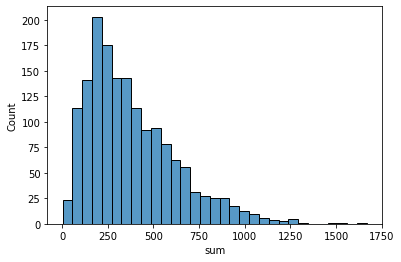

In [34]:
sns.histplot(all_sales_create_ord.query('group == 0'), x='sum')

Проверка показала, что распределение не нормальное

In [35]:
stats.shapiro(all_sales_create_ord.query('group == 0')['sum'])

ShapiroResult(statistic=0.9185957908630371, pvalue=1.347362172388217e-28)

##### Тестовая группа

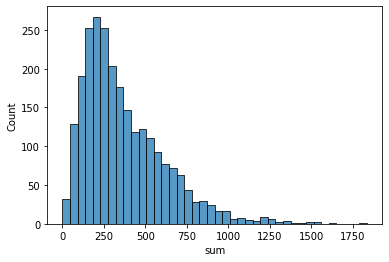

In [36]:
sns.histplot(all_sales_create_ord.query('group == 1'), x='sum')

Проверка тестовой группы тоже показала, что распределение не нормальное

In [37]:
stats.shapiro(all_sales_create_ord.query('group == 1')['sum'])

ShapiroResult(statistic=0.9023671746253967, pvalue=2.2913337444601104e-37)

##### Посмотрим на распределение средних чеков пользователей
##### Контрольная группа

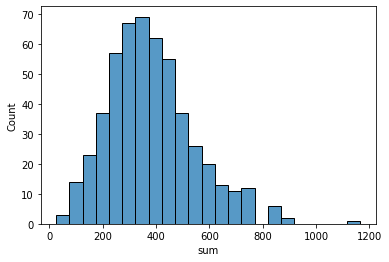

In [38]:
AOV_control = all_sales_create_ord.query('group == 0').groupby('user_id', as_index = False).agg({'sum' : 'mean'})

sns.histplot(AOV_control, x='sum')

Тут распределения кажутся более нормальными. Проведём проверку - нет, оба не нормальные

In [39]:
stats.shapiro(AOV_control['sum'])

ShapiroResult(statistic=0.9676896333694458, pvalue=3.1783389253803307e-09)

##### Тестовая группа

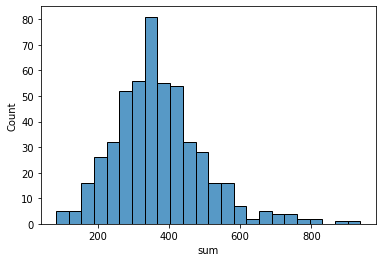

In [40]:
AOV_test = all_sales_create_ord.query('group == 1').groupby('user_id', as_index = False).agg({'sum' : 'mean'})
sns.histplot(AOV_test, x='sum')

In [41]:
stats.shapiro(AOV_test['sum'])

ShapiroResult(statistic=0.9591400623321533, pvalue=1.4000435533123579e-10)

##### Также поглядим, какой общий средний чек у тестовой и контрольной групп - у контрольной он немного больше

In [42]:
all_sales_create_ord.query('group == 0')['sum'].mean()

381.2857675574892

In [43]:
all_sales_create_ord.query('group == 1')['sum'].mean()

369.6229116945107

- H0 - нововведение не повлияло на средний чек пользователей
- H1 - нововведение привело к статзначимым изменениям в среднем чеке пользователей

### Проведение AB-теста
#### Средние чеки пользователей - количественные данные, распределены не нормально, группы независимые и их две, применяем критерий Манна-Уитни

In [44]:
stats.mannwhitneyu(AOV_test['sum'], AOV_control['sum'])

MannwhitneyuResult(statistic=127228.0, pvalue=0.6636667887942074)

### (!)Распределения статзначимо не различаются. Средние чеки пользователей похожи

## Метрика 2. Количество товаров в заказе на пользователя
Умная система рекомендаций скорее всего может повлиять на "добор" пользователем товаров, то есть на увеличение количества продуктов в заказе, проверим это.

#### Формирование гипотез

- H0 - нововведение не повлияло на изменение количества продуктов в заказе
- H1 - нововведение привело к изменениям количества

##### Напомню, что мы используем датафрейм, где каждый продукт в заказе разнесен в отдельную строку. Он сделан на основе датафрейма, где отмен нет, поэтому тут 13826 строк:

In [45]:
sum_on_checks.shape

(13826, 5)

##### Объединяем его с датафреймом о поведении юзеров, где отмены есть, строк станет больше за счёт отмен. Поэтому ставим фильтр только самих заказов и сравниваем количество строк - сходится

In [46]:
sum_on_checks.merge(ab_users_data, on = 'order_id', how = 'inner').query('action == "create_order"').shape

(13826, 10)

##### Мы готовы и делаем группировку по заказам и считаем количество покупок в заказе для контрольной группы:

In [47]:
Control_count_producs = sum_on_checks.merge(ab_users_data, on = 'order_id', how = 'inner') \
                        .query('action == "create_order"') \
                        .query('group == 0').groupby('order_id', as_index = False) \
                        .agg({'check':'count'})

##### И для тестовой группы:

In [48]:
Test_count_producs = sum_on_checks.merge(ab_users_data, on = 'order_id', how = 'inner') \
                        .query('action == "create_order"') \
                        .query('group == 1').groupby('order_id', as_index = False) \
                        .agg({'check':'count'})

### Визуализация

##### Посмотрим на распределение количества покупок среди покупателей в контрольной группе.

Вариантов немного, чаще всего покупают по 2-4 товара.

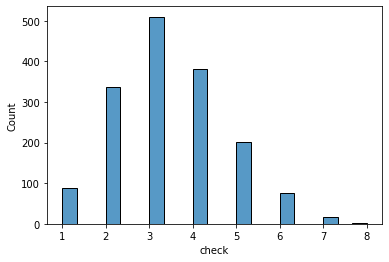

In [49]:
sns.histplot(Control_count_producs, x = 'check')

Раз значений не так много, то посмотрим на абсолютные данные, чтобы потом сравнить с тестовой группой.

In [50]:
Control_count_producs.groupby('check', as_index = False).agg({'order_id':'count'})

,check,order_id
0,1,89
1,2,336
2,3,510
3,4,381
4,5,201
5,6,75
6,7,16
7,8,1


##### Проведём тест на нормальность - расроеделение не нормальное.

In [51]:
stats.shapiro(Control_count_producs['check'])

ShapiroResult(statistic=0.9363436102867126, pvalue=1.1053166481739797e-25)

##### В таком же ключе рассмотрим тестовую группу

In [52]:
Test_count_producs.groupby('check', as_index = False).agg({'order_id':'count'})

,check,order_id
0,1,155
1,2,537
2,3,728
3,4,612
4,5,342
5,6,119
6,7,17
7,8,4


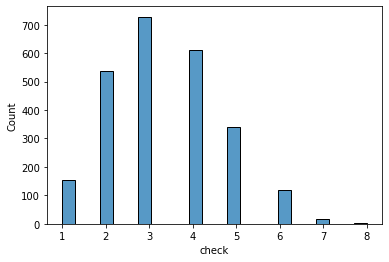

In [53]:
sns.histplot(Test_count_producs, x = 'check')

- Визуализация показывает, что распределение очень похоже на распределение контрольной группы, в ТОПе по количеству - 2-4 товара в чеке. 
- А абсолютные цифры вместе с визуализацией говорят, что при сохранении этой тенденции общее количество заказов почти в каждом сегменте больше, чем у контрольной группы, особенно в ТОПе (где 2-4). Кстати, мы помним, что в целом количество заказов в тестовой группе значительно больше.
- Распределение у тестовой группы также не нормальное. 

In [54]:
stats.shapiro(Test_count_producs['check'])

ShapiroResult(statistic=0.9398516416549683, pvalue=8.551399786977757e-31)

### Проведение AB-теста
#### Количество товаров в чеке - количественные данные, распределены не нормально, группы независимые и их две, вновь применяем критерий Манна-Уитни

In [55]:
stats.mannwhitneyu(Test_count_producs['check'], Control_count_producs['check'])

MannwhitneyuResult(statistic=2031815.0, pvalue=0.797659849654466)

### (!)Распределения статзначимо не различаются. При нововведении покупатели больше товаров корзину класть не стали.

## Метрика 3. Количество заказов на пользователя
Мы уже выяснили, что абсолютное число заказов втестовой группе значтельно больше. Посмотрим на распределения количества заказов на пользователя. А то может в тестовой группе оказалась пара олигархов или людей, победивших в лотерее. 

#### Формирование гипотез

- H0 - пользователи делают примерно столько же заказов 
- H1 - нововведение привело к изменению количества заказов на пользователя

##### Группируем и аггрегируем данные из датафрейма с историей действий пользователей, там есть и юзеры и все заказы. Конечно же, вновь не берём в расчёт отмены.

In [56]:
Control_order_count = ab_users_data.query('action == "create_order"').query('group == 0') \
                        .groupby('user_id', as_index = False).agg({'order_id' : 'count'})
Control_order_count.head()

,user_id,order_id
0,964,2
1,966,1
2,968,3
3,969,2
4,972,1


In [57]:
Test_order_count = ab_users_data.query('action == "create_order"').query('group == 1') \
                        .groupby('user_id', as_index = False).agg({'order_id' : 'count'})
Test_order_count.head()

,user_id,order_id
0,965,9
1,967,5
2,970,2
3,971,5
4,973,4


### Визуализация

##### Видим довольно разные распределения. В тестовой группе выше доля заказов на пользователя, в ТОПе оказались 4-5 заказов на пользователя, 6-7 тоже бывает довольно часто.

##### В контрольной группе пользователь делал чаще 1-3 заказа

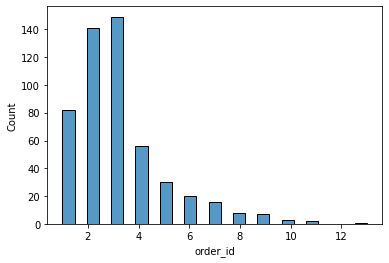

In [58]:
sns.histplot(Control_order_count, x='order_id')

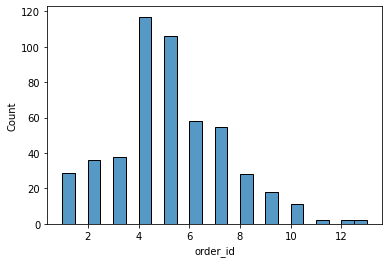

In [59]:
sns.histplot(Test_order_count, x='order_id')

##### Проведём тесты на нормальность, вновь оба распределения не нормальны.

In [60]:
stats.shapiro(Control_order_count.order_id)

ShapiroResult(statistic=0.8348702788352966, pvalue=1.0818117861129074e-22)

In [61]:
stats.shapiro(Test_order_count.order_id)

ShapiroResult(statistic=0.9596871137619019, pvalue=1.7252431427916548e-10)

### Проведение AB-теста
#### Количество заказов - количественные данные, распределены не нормально, группы независимые и их две, и опять применяем критерий Манна-Уитни

In [62]:
stats.mannwhitneyu(Control_order_count.order_id, Test_order_count.order_id)

MannwhitneyuResult(statistic=61172.5, pvalue=6.987139829766148e-49)

### (!) Здесь мы видим статистически значимые различия. В тестовой и контрольной группах количество заказов отличается, в тестовой заказывали больше.

## Метрика 4. Oбщая выручка
Для общего понимания мы должны знать и общую выручку, которую принесли примерно равные по количеству пользователей группы (контрольная и тестовая)

#### Без учёта отмен
Берём датафрейм с суммами всех заказов без отмен

In [63]:
all_sales_create_ord.query('group == 0')['sum'].sum()

613488.8

In [64]:
all_sales_create_ord.query('group == 1')['sum'].sum()

929232.0

#### С учётом отмен

In [65]:
cancel_orders = all_sales.query('action == "cancel_order"').order_id.to_list()

In [66]:
all_sales.query('order_id != @cancel_orders').query('group == 0')['sum'].sum()

583455.9

In [67]:
all_sales.query('order_id != @cancel_orders').query('group == 1')['sum'].sum()

878628.4

### (!) Общая выручка увеличилась почти в полтора раза, как без учёта отмен, так и с их учётом

## Дополнительно 1. Взглянем на покупаемые товары.

##### Найдём ID заказов тестовой и контрольной группы

In [68]:
control_orders = ab_users_data.query('group == 0').order_id.to_list()

test_orders = ab_users_data.query('group == 1').order_id.to_list()

##### Создадим словарь с ключами - ID продуктов, значениями - наименованиями товаров

In [69]:
dictionary_products = dict(zip(ab_products.product_id, ab_products.name))

##### Создадим датафреймы с распределением покупок всех товаров в контрольной и тестовой групах

In [70]:
control_products = sum_on_checks.query('order_id == @control_orders') \
                    .groupby('check', as_index = False).agg({'order_id':'count'})
control_products['check'] = control_products['check'].map(dictionary_products)
control_products.head()

,check,order_id
0,сахар,104
1,чай зеленый в пакетиках,67
2,вода негазированная,99
3,леденцы,39
4,кофе 3 в 1,94


In [71]:
test_products = sum_on_checks.query('order_id == @test_orders') \
                    .groupby('check', as_index = False).agg({'order_id':'count'})
test_products['check'] = test_products['check'].map(dictionary_products)
test_products.head()

,check,order_id
0,сахар,181
1,чай зеленый в пакетиках,128
2,вода негазированная,145
3,леденцы,66
4,кофе 3 в 1,151


## Визуализация
- Построим барплот, на котором отобразим все наименования продуктов в отношении к группам. В тестовой группе заказов больше, поэтому она у нас на заднем фоне и потемнее. 

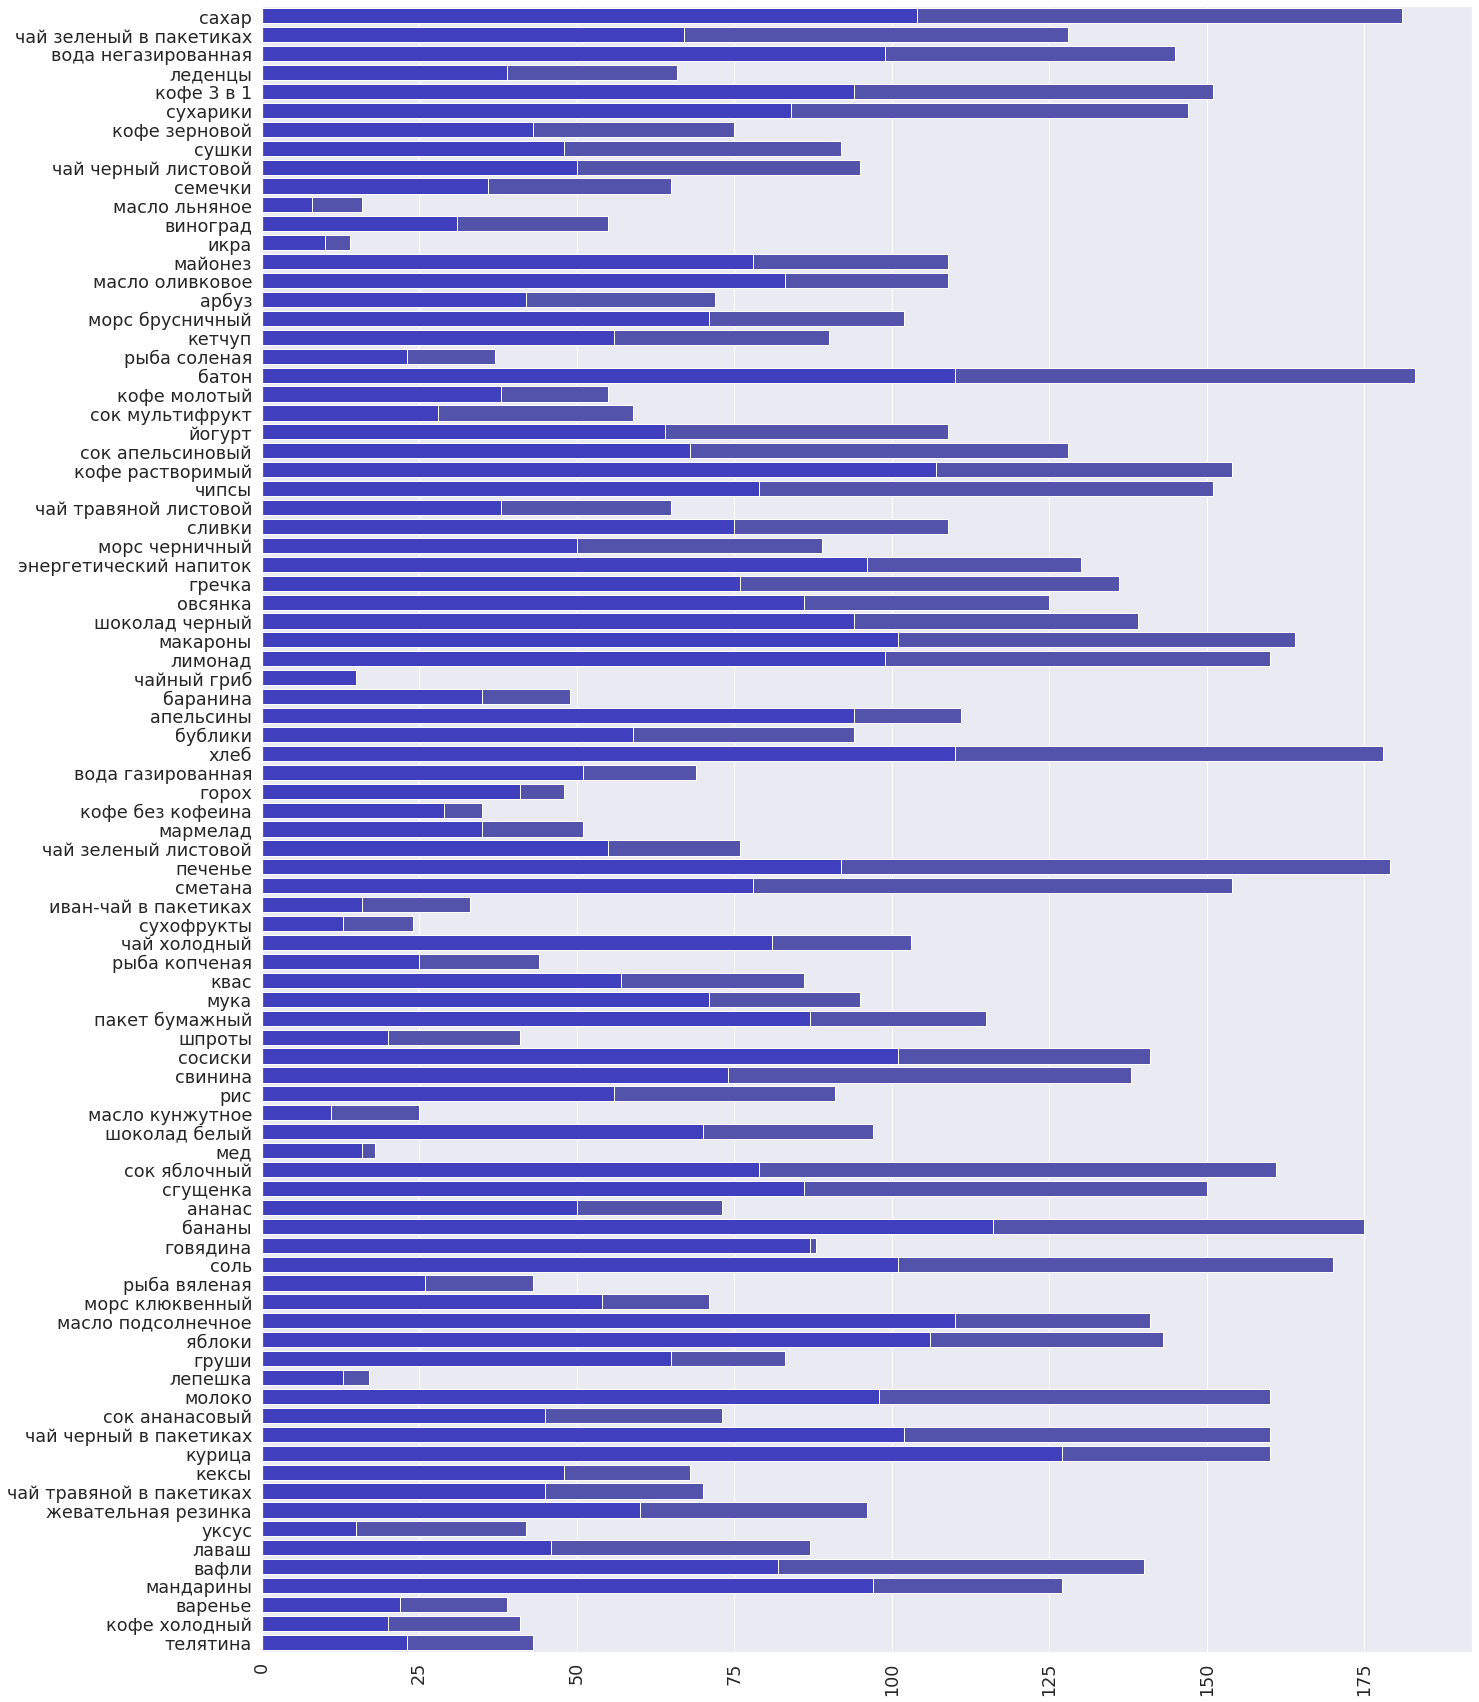

In [72]:
sns.set(rc={'figure.figsize':(21.7,30.27)}, font_scale=1.6)
ax_1 = sns.barplot(data = test_products, x="order_id", y="check", color = 'blue', saturation=0.35)
ax_2 = sns.barplot(data = control_products, x="order_id", y="check", color = 'blue', saturation=0.5)

ax_1.tick_params(axis='x', labelrotation=90)
ax_1.set_ylabel('')    
ax_2.set_xlabel('')
plt.show()


- Видно, что покупать больше стали почти все наименования товаров. И разница часто в полтора-два раза больше в пользу тестовой группы.
- Спрос на говядину, лепёшки и мёд наши умные рекомендации почти не подняли. А если сравнить эти позиции с другими товарами - это скорее деградация спроса.
- И абсолютно нет продуктового развития у чайного гриба :(

## Дополнительно_2. Посчитаем время между заказами.
Узнаем, меньше ли время от заказа до заказа в тестовой группе, чем в контрольной. Мы знаем, что от умных рекомендаций не увеличилась корзина пользователя, но заказов стало больше. Если время между заказами небольшое или сократилось, то сможем сказать увереннее, что умные рекомендации влияют и мотивируют покупать сразу.
Для этого требуется значительное исследование, мы же проведём короткое и поверхностное, чтобы только заметить тенденцию и приобщить к аргументам. При необходимости развернём большое.

In [73]:
import datetime

##### Cоздадим в датафрейме с историей заказов колонку, в которой время заказа переведено в тип datetime

In [74]:
ab_users_data['time_01'] = pd.to_datetime(ab_users_data.time)

##### Cоздадим датафрейм, в котором в контрольной группе сделаем группировку и оставим всех пользователей и каждое время их заказаов.

In [75]:
Date_df_0 = ab_users_data.query('group == 0').groupby(['user_id', 'time_01'], as_index = False).agg({'time' : 'count'})
Date_df_0

,user_id,time_01,time
0,964,2022-08-26 00:00:19.000000,1
1,964,2022-08-26 00:02:27.000000,1
2,966,2022-08-26 00:02:56.000000,1
3,966,2022-08-26 00:08:25.486419,1
4,968,2022-08-26 00:05:35.000000,1
...,...,...,...
1685,1973,2022-09-04 21:59:33.000000,1
1686,1974,2022-08-26 23:39:00.000000,1
1687,1974,2022-08-27 19:11:56.000000,1
1688,1974,2022-09-03 21:21:57.000000,1


##### Сделаем в этом датафрейме группировку по пользователям и посчитаем разницу между временем их заказов (соответственно первое значение у пользователя будет пропущено).

In [261]:
Date_df_0['diff'] = Date_df_0.groupby('user_id')['time_01'].diff()

##### Уберём пропущенные значения, чтобы получить в первой строке на каждого пользователя разницу между первым и вторым заказом.

In [262]:
Date_df_0 = Date_df_0.dropna()

In [263]:
Date_df_0.head()

,user_id,time_01,time,diff
1,964,2022-08-26 00:02:27.000000,1,0 days 00:02:08
3,966,2022-08-26 00:08:25.486419,1,0 days 00:05:29.486419
5,968,2022-08-30 22:01:32.000000,1,4 days 21:55:57
6,968,2022-08-31 05:27:34.000000,1,0 days 07:26:02
8,969,2022-08-28 08:14:39.000000,1,2 days 08:08:14


##### Создадим функцию, возвращающую только первое значение, то есть разницу между первым и вторым заказом в нашем случае

In [264]:
def first_diff(x):
    return x.iloc[0]

##### В итоге получаем датафрейм с распределением разницы между первым и вторым заказом у каждого пользователя контрольной группы, который делал больше одного заказа.

In [265]:
Diff_control = Date_df_0.groupby('user_id', as_index = False)['diff'].apply(first_diff)
Diff_control.head()

,user_id,diff
0,964,0 days 00:02:08
1,966,0 days 00:05:29.486419
2,968,4 days 21:55:57
3,969,2 days 08:08:14
4,975,3 days 19:31:10


##### Делаем колонку с днями, переведёнными в часы и с часами, суммируем их, чтобы получить колонку с часами между 1 и 2 заказом каждого пользователя контрольной группы.

In [266]:
Diff_control['diff_d'] = Diff_control['diff'].dt.components['days'] * 24

In [267]:
Diff_control['diff_h'] = Diff_control['diff'].dt.components['hours'] + Diff_control['diff_d']

In [269]:
Diff_control.head()

,user_id,diff,diff_d,diff_h
0,964,0 days 00:02:08,0,0
1,966,0 days 00:05:29.486419,0,0
2,968,4 days 21:55:57,96,117
3,969,2 days 08:08:14,48,56
4,975,3 days 19:31:10,72,91


##### Проведём такие же манипуляции с тестовой группой.

In [272]:
Date_df_1 = ab_users_data.query('group == 1').groupby(['user_id', 'time_01'], as_index = False).agg({'time' : 'count'})
Date_df_1['diff'] = Date_df_1.groupby('user_id')['time_01'].diff()
Date_df_1 = Date_df_1.dropna()
Diff_test = Date_df_1.groupby('user_id', as_index = False)['diff'].apply(first_diff)

In [273]:
Diff_test['diff_d'] = Diff_test['diff'].dt.components['days'] * 24
Diff_test['diff_h'] = Diff_test['diff'].dt.components['hours'] + Diff_test['diff_d']

In [274]:
Diff_test.head()

,user_id,diff,diff_d,diff_h
0,965,1 days 15:11:38,24,39
1,967,0 days 08:41:11,0,8
2,970,1 days 08:49:17,24,32
3,971,0 days 00:01:48,0,0
4,973,3 days 04:27:54,72,76


### Визуализация
Построим графики распределения разницы между первым и вторым заказом в контрольной и тестовой группах. Красный график - это контрольная группа

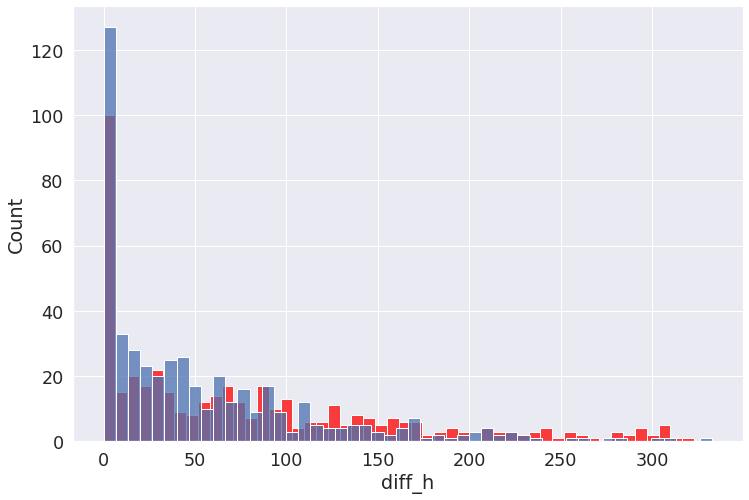

In [292]:
sns.set(rc={'figure.figsize':(12,8)}, font_scale=1.6)
sns.histplot(Diff_control, x="diff_h", color = 'red', bins=50)
sns.histplot(Diff_test, x="diff_h", bins=50)

Распределения явно не нормальные, посмотрим на медианы обоих.

In [293]:
Diff_test.diff_h.median()

35.5

In [294]:
Diff_control.diff_h.median()

58.0

Попробуем нащупать здесь сутки c помощью quantile

In [332]:
Diff_control.diff_h.quantile(q=0.344)

24.0

In [321]:
Diff_test.diff_h.quantile(q=0.42)

24.0

In [326]:
Diff_test.diff_h.quantile(q=0.3)

9.0

In [330]:
Diff_test.diff_h.quantile(q=0.2)

2.6000000000000085

- мы видим, что ситуация в тестовой группе стабильнее, при большем количестве заказов (и, соответственно, наблюдений), большая часть из них стремится к малому времени.
- в обеих группах первый и второй заказы сделаны часто в течение нескольких часов. Вкупе со значениями медиан становится понятно, что в тестовой группе наблюдается меньшее время до нового заказа. Медианное значение почти вдвое ниже (а значит лучше для продаж).
- В тестовой группе половина пользователей делала повторный заказ в приложении в течение полутора суток.
- Больше 40% пользователей тестовой группы делали повторный заказ в течение суток (большинство из них (30% от всех) в течение первых 9 часов). В контрольной же группе в около 30% пользователей делали повторный заказ в течение суток.

#### Сформируем гипотезу

- H0 - время между первым и вторым заказом у пользователей тестовой и контрольной групп примерно одинаково
- H1 - нововведение привело к изменению (желательно сокращению) времени между первым и вторым заказом у тестовой группы

### Проведение AB теста
Проверим статистическую значимость отличия этих распределений. Хоть данные у нас довольно скудные.

##### Для начала убедимся, что распределения действительно не нормальны

In [117]:
stats.shapiro(Diff_test['diff_h'])

ShapiroResult(statistic=0.7784740328788757, pvalue=7.83283806532519e-25)

In [295]:
stats.shapiro(Diff_control['diff_h'])

ShapiroResult(statistic=0.8619078397750854, pvalue=3.6680261853564764e-19)

##### По ранее обозначенным в нескольких пунктах признакам выбираем критерий Манна-Уитни

In [296]:
stats.mannwhitneyu(Diff_control['diff_h'], Diff_test['diff_h'])

MannwhitneyuResult(statistic=119430.5, pvalue=3.474922691755394e-05)

### (!) Мы видим, что распределения отличаются друг от друга статистически значимо. Действительно, время от первого до второго заказа в приложении у пользователей в тестовой группе оказалось меньшим.

## Выводы

<font size=3,5>
      Умная система рекомендаций должна привести к некоторому улчшению качества приложения, котрое при этом будет положительно влиять на бизнес. Проведя анализ и некоторые AB-тесты, мы можем указать на следующие аспекты:</font><br><br>
   <font size=3,5> 
- Тестовая и контрольная группы почти одинаковы по количеству покупателей.<br><br>
- В тестовой группе стало значительно больше заказов (по абсолютным значениям).<br><br>
- Средний чек на пользователя статистически значимо не изменился, значит на сумму заказа изменение не повлияло. Кроме того, общий средний чек контрольной группы даже выше, чем у тестовой.<br><br>
- Количество товаров в заказе тоже не изменилось. То есть "добора" в рамках одного заказа нет, умные рекомендации не работают на покупателя сразу, не мотивируют его купить больше товаров.<br><br>
- Количество заказов на пользователя увеличилось статистически значимо. После зпокупки люди стали в какой-то момент возвращаться в приложение и делать ещё заказы.<br><br>
- Кроме того, в тестовой группе общая выручка выше в полтора раза.<br><br>
- Относительно наименований покупаемых товаров каких-то аномалий не выявленно. В тестовой группе, где больше заказов, все наименования товаров пользуются пропорционально большим спросом, чем в контрольной. Покупки каждого товара больше примерно в полтора-два раза, за редким исключением. Это говорит, что умные рекомендации не выводят каки-то определённые товары, чтобы усилить их продажи. <br><br>
- Отмечается статзначимое различие во времени от первого заказа до второго. В тестовой группе пользователи делали второй заказ значительно раньше. (Мы не проводили глубокого исследования, связанного с поведением пользователей и временем заказов)</font>

----

<font size=3,5> 
Таким образом, при введении умных рекомендаций "добора товаров на месте" у пользователей  не происходит, люди не хотят покупать большее количество товаров, они возвращаются позже для новой покупки. <br> Средний чек не поменялся, то есть покупатели не готовы отдавать бОльшие деньги за заказ. Также они не решают купить товар подороже и получше (при схожем количестве товаров в чеке больший AOV в тестовой группе показал бы, что стали покупать более дорогие товары).  <b>Если умные рекомендации были направленны конкретно на эти аспекты, то катить их не следует</b>.
    
Время обращения за новым заказом значительно меньше в тестовой группе, многие покупают в течение 9 часов, однако, тотального сокращения при нашей небольшой проверке не обнаружилось. В принципе, и в контрольной группе вторая покупка тоже часто совершалась в первые сутки. А каких-то серьёзных колебаний в сторону покупки через 1-2 часа после того, как был сделан первый заказ и просмотренны умные рекомендации, не наблюдается (возможно требуется хорошее исследование на эту тему). <b> Тем не менее то, что время от первого до второго заказа статистически значимо меньше в тестовой группе - весомый аргумент в сторону того, чтобы катить нововведение </b>.
<br><br>
Интересы пользователей к определённым наименованиям товаров почти одинаковы в тестовой и контрольной группах. Все товары пользуются таким же спросом, увеличились только объёмы продаж (почти пропорционально). Заметим, что это продукты повседневного спроса и довольно различные, то есть одним (например, более дорогим) другой, как правило, не заменишь, то есть нужен и тот и другой (и сахар, и чай). Как раз увеличение количества товаров в чеке показало бы настоящее улучшение.
<br><br>
Однако, пользователи действительно стали делать больше заказов, что влияет на общую выручку, которая значительно больше в тестовой группе (даже не смотря на некоторые отмены). Это говорит о том, что нововведение положительно сказалось на основополагающем показателе бизнеса. <b>Если других более узких целей у введения умных рекомендаций не было, то катить нововведение точно следует, особенно принимая во внимание аспект сокращения времени между 1 и 2 заказами.</b> 
    </font> 

##### Задание взято из программы обучения на Аналитика данных  в Karpov Courses